In [ ]:
import os
import sys

In [ ]:
import torch
import numpy as np
import torchvision as tv
from torch import nn, optim
import pickle
import reliability_diagram
import matplotlib.pyplot as plt
from models import DenseNet
import torch.nn.functional as F
from reliability_diagram import reliability_diagram
import temperature_scaling
import platt_scaling
from demo import demo
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.metrics import accuracy_score

In [ ]:
data = 'data/'
save = 'model/'

block_config = [(40 - 4) // 6 for _ in range(3)]

In [ ]:
def plot_calibration(model, data, test = False):
    # Data transforms
    mean = [0.5071, 0.4867, 0.4408]
    stdv = [0.2675, 0.2565, 0.2761]
    test_transforms = tv.transforms.Compose([
        tv.transforms.ToTensor(),
        tv.transforms.Normalize(mean=mean, std=stdv),
    ])
    if test :
        dataset = tv.datasets.CIFAR100(data, train=False, transform=test_transforms, download=False)
        loader = torch.utils.data.DataLoader(dataset, pin_memory=True, batch_size=64)
    else:
        valid_indices_filename = os.path.join(save, 'valid_indices.pth')
        if not os.path.exists(valid_indices_filename):
            raise RuntimeError('Cannot find file %s to load' % valid_indices_filename)
        valid_indices = torch.load(valid_indices_filename)
        dataset = tv.datasets.CIFAR100(data, train=True, transform=test_transforms, download=True)
        loader = torch.utils.data.DataLoader(dataset, pin_memory=True, batch_size=64,
                                               sampler=SubsetRandomSampler(valid_indices))

    y_true = []
    y_pred = []
    confidences = []

    print('Computing outputs')
    for _, (input, label) in enumerate(loader):
        out_model = F.softmax(model(input.cuda()),1)
        prob_pred, labels_pred = torch.max(out_model,1)

        y_true += list(label.cpu().detach().numpy())
        y_pred += list(labels_pred.cpu().detach().numpy())
        confidences += list(prob_pred.cpu().detach().numpy())

    print("Accuracy score {}".format(accuracy_score(y_true, y_pred)))

    print('Computing diagram')
    reliability_diagram(np.array(y_true), np.array(y_pred), np.array(confidences), num_bins=10,
        draw_ece=False, draw_bin_importance=False,
        draw_averages=False, title="Reliability Diagram",
        figsize=(6, 6), dpi = 72, return_fig = False)

#Calibrating models

In [ ]:
demo(data, 'Platt', save, depth=40, growth_rate=12, batch_size=256)
demo(data, 'Temperature', save, depth=40, growth_rate=12, batch_size=256)

Files already downloaded and verified
Platt scaling
Before Platt - NLL: 2.086, ECE: 0.206
After Platt - NLL: 1.433, ECE: 0.046
Scaled model sved to /content/drive/My Drive/Etudes/Deep learning/model/model_with_Platt.pth
Done!
Files already downloaded and verified
Temperature
Before temperature - NLL: 2.078, ECE: 0.208
Optimal temperature: 2.416
After temperature - NLL: 1.424, ECE: 0.017
Scaled model sved to /content/drive/My Drive/Etudes/Deep learning/model/model_with_Temperature.pth
Done!


# Validation set

In [ ]:
model = DenseNet(
    growth_rate=12,
    block_config=block_config,
    num_classes=100
).cuda()

params = torch.load(save + 'model.pth')
model.load_state_dict(params)

<All keys matched successfully>

##No Calibration

Files already downloaded and verified
Computing outputs
Accuracy score 0.6078
Computing diagram


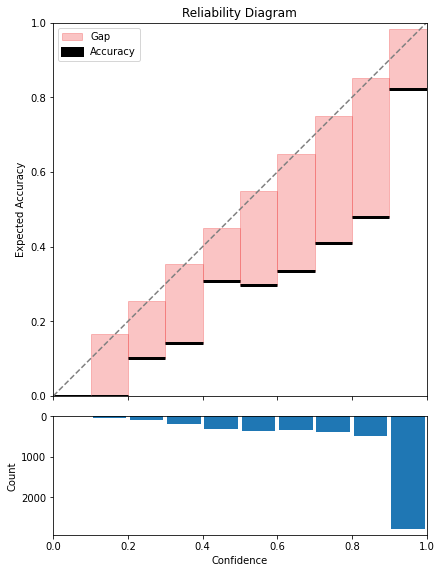

In [ ]:
plot_calibration(model, data, test=False)

## Temperature

In [ ]:
model_temp = DenseNet(
        growth_rate=12,
        block_config=block_config,
        num_classes=100
    )
model_temp = temperature_scaling.ModelWithTemperature(model_temp).cuda()
params = torch.load(save + 'model_with_Temperature.pth')
model_temp.load_state_dict(params)

<All keys matched successfully>

Files already downloaded and verified
Computing outputs
Accuracy score 0.604
Computing diagram


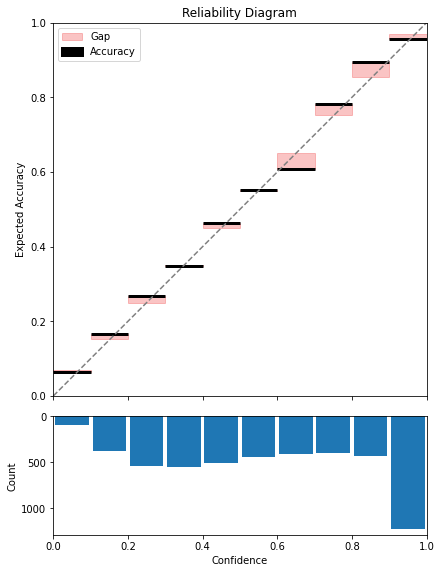

In [ ]:
plot_calibration(model_temp, data, test=False)

##Platt scaling

In [ ]:

model_temp = DenseNet(
  growth_rate=12,
  block_config=block_config,
  num_classes=100
)
model_temp = platt_scaling.ModelWithPlatt(model_temp).cuda()
params = torch.load(save + 'model_with_Platt.pth')
model_temp.load_state_dict(params)

<All keys matched successfully>

Files already downloaded and verified
Computing outputs
Accuracy score 0.615
Computing diagram


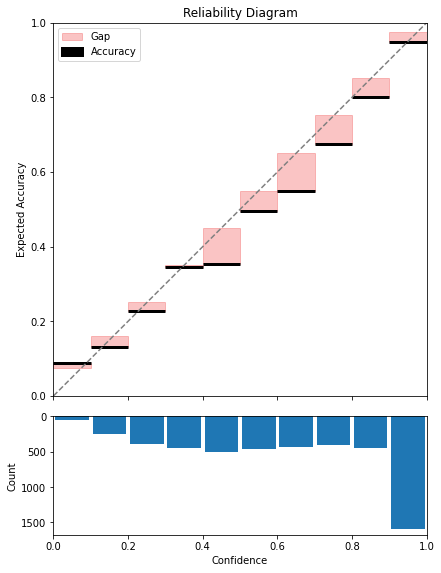

In [ ]:
plot_calibration(model_temp, data, test=False)

# Test set

## Base network

In [ ]:
model = DenseNet(
    growth_rate=12,
    block_config=block_config,
    num_classes=100
).cuda()

params = torch.load(save + 'model.pth')
model.load_state_dict(params)

<All keys matched successfully>

Computing outputs
Accuracy score 0.5884
Computing diagram


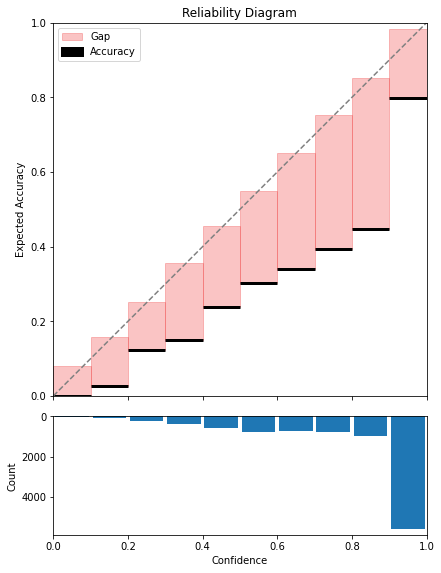

In [ ]:
plot_calibration(model, data, test=True)

## Temperature scaling

In [ ]:
 model_temp = DenseNet(
        growth_rate=12,
        block_config=block_config,
        num_classes=100
    )
model_temp = temperature_scaling.ModelWithTemperature(model_temp).cuda()
params = torch.load(save + 'model_with_Temperature.pth')
model_temp.load_state_dict(params)

<All keys matched successfully>

Computing outputs
Accuracy score 0.5884
Computing diagram


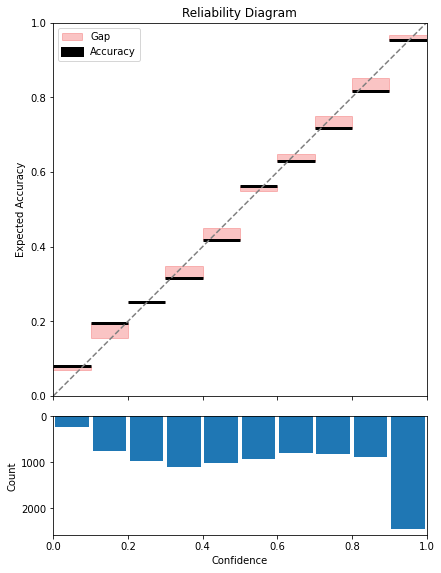

In [ ]:
plot_calibration(model_temp, data, test=True)

## Platt scaling

In [ ]:

model_temp = DenseNet(
  growth_rate=12,
  block_config=block_config,
  num_classes=100
)
model_temp = platt_scaling.ModelWithPlatt(model_temp).cuda()
params = torch.load(save + 'model_with_Platt.pth')
model_temp.load_state_dict(params)

<All keys matched successfully>

Computing outputs
Accuracy score 0.5888
Computing diagram


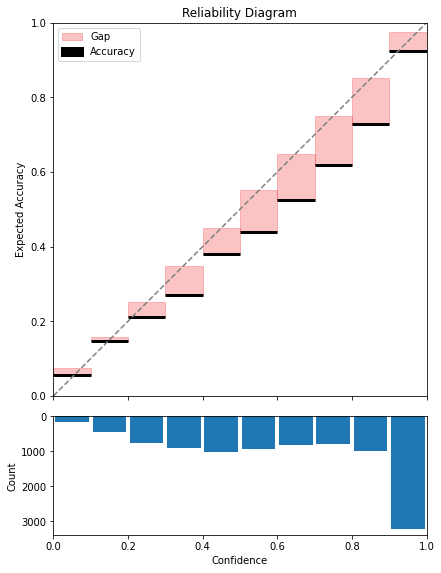

In [ ]:
plot_calibration(model_temp, data, test=True)